In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from utils import Processor, EnsembleClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import pandas as pd
import telepot
%matplotlib inline

from sklearn import svm,cross_validation,tree,linear_model,preprocessing,metrics
from sklearn.mixture import GMM
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB

In [2]:
# os.chdir('/')
trainFid = 'KDDTrain+_20Percent.txt'
testFid = 'KDDTest-21.txt'
bot = telepot.Bot('258510570:AAHujlmQqiZ_L4yrWMR9HtuE-0rK8xXo-XY')

## 資料前處理

In [3]:
traindata, attack_type_list = Processor.cleanData(trainFid)
test_data_len = 1000
traindata_len = len(traindata) - test_data_len
testdata = traindata[traindata_len - test_data_len:]
traindata = traindata[:traindata_len - test_data_len]
# testdata, _ = Processor.cleanData(testFid)
traindata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,0
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0


In [4]:
attack_type_list

['normal', 'dos', 'r2l', 'probe', 'u2r']

In [5]:
traindata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23192 entries, 0 to 23191
Data columns (total 42 columns):
duration                       23192 non-null int64
protocol_type                  23192 non-null object
service                        23192 non-null object
flag                           23192 non-null object
src_bytes                      23192 non-null int64
dst_bytes                      23192 non-null int64
land                           23192 non-null int64
wrong_fragment                 23192 non-null int64
urgent                         23192 non-null int64
hot                            23192 non-null int64
num_failed_logins              23192 non-null int64
logged_in                      23192 non-null int64
num_compromised                23192 non-null int64
root_shell                     23192 non-null int64
su_attempted                   23192 non-null int64
num_root                       23192 non-null int64
num_file_creations             23192 non-null int64
num_

#### 1. 檢視攻擊種類分佈

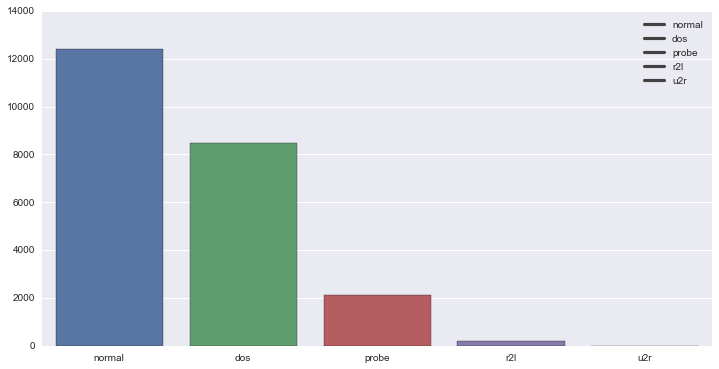

In [6]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(traindata['attack_type'].value_counts())), y=traindata['attack_type'].value_counts().tolist())
attack_t = [attack_type_list[i] for i in traindata['attack_type'].value_counts().index]
plt.legend(attack_t,loc=0)
ax.set_xticklabels(attack_t)

#### 2. 資料標準化

In [7]:
data_all = pd.concat([traindata, testdata])
traindata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[:len(traindata)]
testdata_df = pd.get_dummies(
    Processor.normalize(data_all.drop(['attack_type'], axis=1)))[len(traindata):]
traindata_df['attack_type'] = traindata['attack_type']
testdata_df['attack_type'] = testdata['attack_type']
anomalydata_df = traindata_df[traindata_df['attack_type']!=0]
anomalydata_df.index = range(0, len(anomalydata_df))
normaldata_df = traindata_df[traindata_df['attack_type']==0]
normaldata_df.index = range(0, len(normaldata_df))

In [8]:
normaldata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.113548,-0.009889,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.113548,-0.010032,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.113548,-0.009996,0.052472,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
3,-0.113548,-0.010010,-0.034581,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.113548,-0.009973,-0.013969,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [9]:
anomalydata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.80761,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
1,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.80761,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.80761,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.80761,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
4,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.80761,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1


In [10]:
testdata.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_type
23192,0,icmp,eco_i,SF,8,0,0,0,0,0,...,254,1.00,0.00,1.00,0.25,0.0,0.00,0.00,0.00,3
23193,0,udp,domain_u,SF,46,46,0,0,0,0,...,245,0.96,0.01,0.00,0.00,0.0,0.00,0.00,0.00,0
23194,0,tcp,finger,S0,0,0,0,0,0,0,...,23,0.22,0.05,0.01,0.09,1.0,0.74,0.00,0.00,1
23195,0,icmp,eco_i,SF,30,0,0,0,0,0,...,4,0.02,0.01,0.07,0.00,0.0,0.00,0.00,0.00,0
23196,0,tcp,http,SF,54540,8314,0,0,0,2,...,87,1.00,0.00,0.01,0.00,0.0,0.00,0.16,0.16,1


#### 3. 異常資料分群

In [11]:
K = 4
kmeans = KMeans(n_clusters=K, random_state=0).fit(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])
clustors = kmeans.predict(anomalydata_df.iloc[:,:anomalydata_df.shape[1]-1])

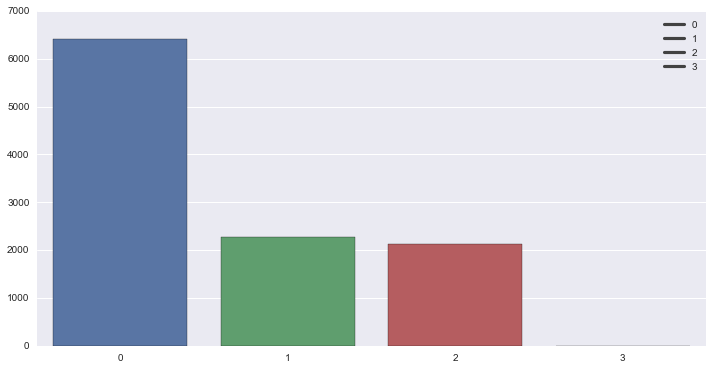

In [12]:
plt.figure(figsize = (12, 6))
ax = sns.barplot(x=range(0, len(pd.Series(clustors).value_counts())), y=pd.Series(clustors).value_counts().tolist())
plt.legend(pd.Series(clustors).value_counts().index.tolist(),loc=0)
ax.set_xticklabels(pd.Series(clustors).value_counts().index.tolist())

In [13]:
try:
    anomalydata_df = anomalydata_df.drop(['clusters'], axis = 1)
except:
    pass
anomalydata_df.insert(0, 'clusters', pd.Series(clustors, dtype=np.int64))

In [14]:
cluster_df = []
for cluster in sorted(anomalydata_df['clusters'].unique()):
    node = anomalydata_df[anomalydata_df['clusters']==cluster]
    node = node.drop(['clusters'], axis=1)
    cluster_df.append(node)

In [15]:
cluster_df[3]['attack_type'].value_counts().sort_index()

3    1
Name: attack_type, dtype: int64

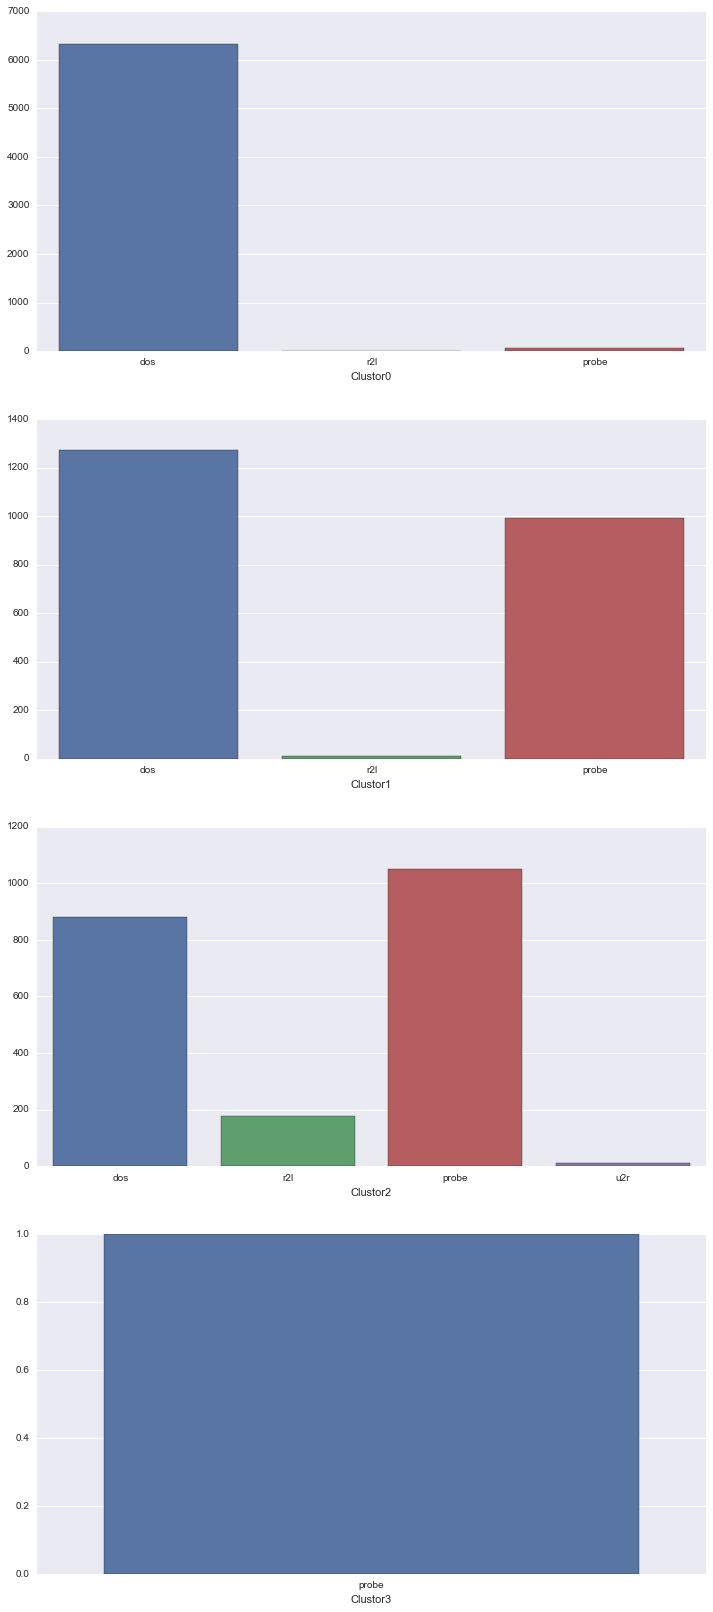

In [16]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

#### 4. 正常資料與異常合併

In [17]:
for index in range(0, len(cluster_df)):
    df = pd.concat([cluster_df[0], normaldata_df], ignore_index = True)
    cluster_df[index] = pd.concat([cluster_df[index], normaldata_df], ignore_index = True)
    cluster_df[index] = cluster_df[index].iloc[np.random.permutation(len(cluster_df[index]))]
    cluster_df[index].index = range(0, len(cluster_df[index]))

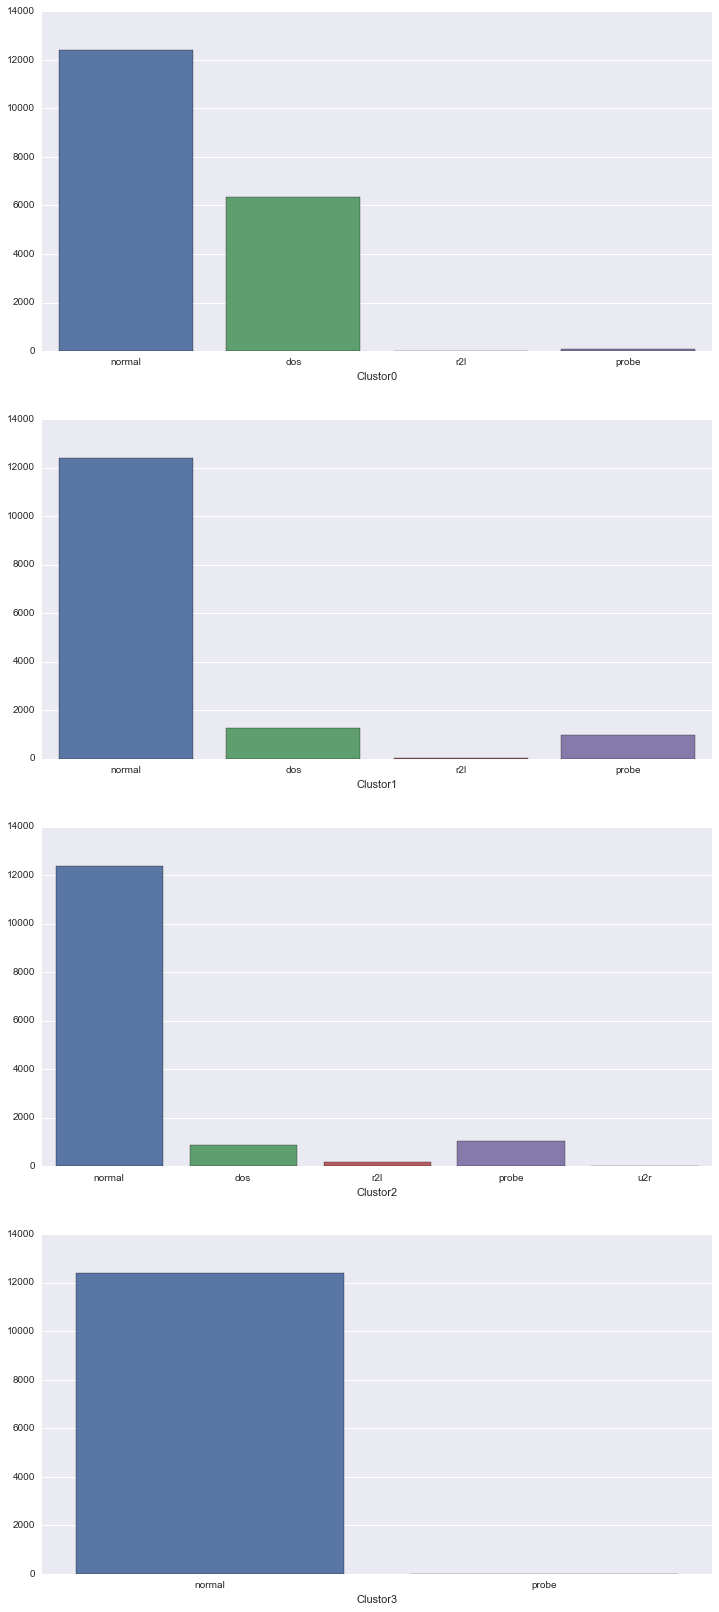

In [18]:
fig, ax = plt.subplots(len(cluster_df), 1, figsize = (12, len(cluster_df) * 7))
for index, cluster in enumerate(cluster_df):
    sns.barplot(x=range(0, len(cluster['attack_type'].value_counts().sort_index()))\
                     , y=(cluster['attack_type'].value_counts().sort_index()).tolist()\
                     , ax = ax[index])
    attack_t = [attack_type_list[i] for i in cluster['attack_type'].value_counts().sort_index().index]
    ax[index].set_xticklabels(attack_t)
    ax[index].set_xlabel("Clustor%d" % index)

## 針對資料進行學習

#### 1. 最簡單的分類器

In [19]:
traindata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
0,-0.113548,-0.009889,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1,-0.113548,-0.010032,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
3,-0.113548,-0.009996,0.052472,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
4,-0.113548,-0.010010,-0.034581,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [20]:
testdata_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
23192,-0.113548,-0.010089,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
23193,-0.113548,-0.010073,-0.038791,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23194,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
23195,-0.113548,-0.010080,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23196,-0.113548,0.012531,0.054285,-0.00891,-0.091221,-0.0063,0.836487,-0.02622,1.238173,0.074122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1


In [21]:
train_x = traindata_df.drop(['attack_type'], axis = 1).values
train_y = traindata_df['attack_type'].values
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
tree = LogisticRegression()
tree.fit(train_x, train_y)
p = tree.predict(test_x)
float(len(np.where(answer == p)[0])) / len(test_x)

0.978

In [22]:
testdata_df

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,attack_type
23192,-0.113548,-0.010089,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3
23193,-0.113548,-0.010073,-0.038791,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23194,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
23195,-0.113548,-0.010080,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23196,-0.113548,0.012531,0.054285,-0.00891,-0.091221,-0.0063,0.836487,-0.02622,1.238173,0.074122,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1
23197,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1
23198,-0.113548,-0.009960,-0.036281,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23199,-0.113548,-0.010002,-0.033883,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0
23200,-0.113548,-0.010092,-0.039309,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,-0.807610,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
23201,-0.113548,-0.009977,-0.014453,-0.00891,-0.091221,-0.0063,-0.091932,-0.02622,1.238173,-0.021872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0


In [23]:
# clf_cluster = [
#     LogisticRegression(),
#     DecisionTreeClassifier(),
#     GaussianNB()
# ]
ks = {'n_neighbors':[3,5,7,9]}
lrParas = {'penalty':['l1','l2'],'C':np.linspace(0.001,1.5,5)}
clf_cluster = [RandomForestClassifier(),\
		DecisionTreeClassifier(),\
		GaussianNB(),\
		AdaBoostClassifier(),\
		GridSearchCV(KNeighborsClassifier(),ks)
		]

In [24]:
en_clf_list = []
for index in range(0, len(cluster_df)):
    train_y = cluster_df[index]['attack_type'].values
    train_x = cluster_df[index].drop(['attack_type'], axis = 1).values
    en = EnsembleClassifier(clf_cluster)
    en.fit(train_x, train_y)
    en_clf_list.append(en)

1


/Users/andy/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:516: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=3.
  % (min_labels, self.n_folds)), Warning)


10
178
0


In [25]:
test_x = testdata_df.drop(['attack_type'], axis = 1).values
answer = testdata_df['attack_type'].values
pre = []
v = []
for clf in en_clf_list:
    predict, vote = clf.predict(test_x)
    pre.append(predict)
    v.append(vote)
float(len(np.where(answer == pre[1])[0])) / len(test_x)

0.5275

In [29]:
len(np.where(v[0]!=v[1])[0])

array([0, 0, 0, ..., 0, 0, 1])

In [28]:
bot.sendMessage('252175743', '多層次分類器運算完了')

{u'chat': {u'first_name': u'\u9673',
  u'id': 252175743,
  u'last_name': u'\u9347\u5609',
  u'type': u'private',
  u'username': u'kaijia'},
 u'date': 1478599171,
 u'from': {u'first_name': u'kaijiabot',
  u'id': 258510570,
  u'username': u'kaijia_bot'},
 u'message_id': 13,
 u'text': u'\u904b\u7b97\u5b8c\u4e86'}